In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# Load
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
cat_cols = df.select_dtypes(['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 × 0.8 = 0.2
for d in (df_train, df_val, df_test):
    d.reset_index(drop=True, inplace=True)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [5]:
target = 'converted'
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

scores = {}
for col in numerical:
    auc = roc_auc_score(df_train[target], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train[target], -df_train[col])
    scores[col] = round(auc, 3)

scores

{'lead_score': 0.614,
 'number_of_courses_viewed': 0.764,
 'interaction_count': 0.738,
 'annual_income': 0.552}

In [6]:
# Prepare features
features = df_train.drop(columns=[target])
y_train = df_train[target]
X_val = df_val.drop(columns=[target])
y_val = df_val[target]

# One-hot encode via DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = features.to_dict(orient='records')
X_train_dv = dv.fit_transform(train_dicts)

val_dicts = X_val.to_dict(orient='records')
X_val_dv = dv.transform(val_dicts)

# Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

y_pred = model.predict_proba(X_val_dv)[:, 1]
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

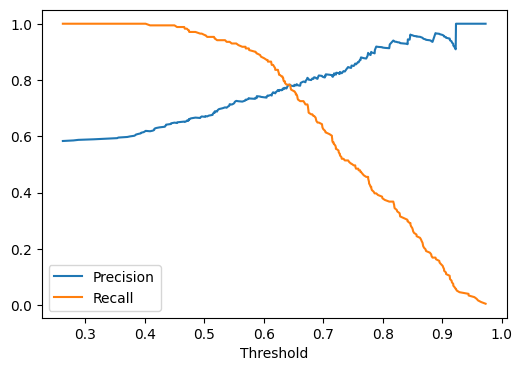

np.float64(0.644)

In [7]:
prec, rec, thresholds = precision_recall_curve(y_val, y_pred)

plt.figure(figsize=(6,4))
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.show()

# Find intersection point (where difference is minimal)
idx = np.argmin(np.abs(prec[:-1] - rec[:-1]))
round(thresholds[idx], 3)

In [8]:
f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1])
best_idx = np.argmax(f1)
round(thresholds[best_idx], 2)

np.float64(0.55)

In [9]:
df_full_train = df_full_train.reset_index(drop=True)
y_full = df_full_train[target]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_tr = df_full_train.iloc[train_idx]
    df_va = df_full_train.iloc[val_idx]
    y_tr, y_va = df_tr[target], df_va[target]
    
    dv = DictVectorizer(sparse=False)
    X_tr = dv.fit_transform(df_tr.drop(columns=[target]).to_dict(orient='records'))
    X_va = dv.transform(df_va.drop(columns=[target]).to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr, y_tr)
    y_pred = model.predict_proba(X_va)[:,1]
    scores.append(roc_auc_score(y_va, y_pred))

mean_auc = np.mean(scores)
std_auc = np.std(scores)
round(mean_auc,3), round(std_auc,3)

(np.float64(0.822), np.float64(0.036))

In [10]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for c in C_values:
    fold_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx]
        df_va = df_full_train.iloc[val_idx]
        y_tr, y_va = df_tr[target], df_va[target]
        
        dv = DictVectorizer(sparse=False)
        X_tr = dv.fit_transform(df_tr.drop(columns=[target]).to_dict(orient='records'))
        X_va = dv.transform(df_va.drop(columns=[target]).to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_tr, y_tr)
        y_pred = model.predict_proba(X_va)[:,1]
        fold_scores.append(roc_auc_score(y_va, y_pred))
    
    results[c] = (round(np.mean(fold_scores),3), round(np.std(fold_scores),3))

results

{1e-06: (np.float64(0.56), np.float64(0.024)),
 0.001: (np.float64(0.867), np.float64(0.029)),
 1: (np.float64(0.822), np.float64(0.036))}